# Evaluación - Redes Convolucionales

**Autor:** Juan Bórquez, Aldo Arroyo

**Fecha de Creación:** 19 de Mayo de 2025

**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la entrega 2 de la asignatura optativa de Deep Learning de DuocUC Sede Concepción

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- tensorflow (2.18.0)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import tensorflow as tf
print(tf.__version__)
````

# Objetivo estudio

En este trabajo se busca entrenar un modelo de redes neuronales convolucionales (CNNs) utilizando Keras, con el objetivo de clasificar imágenes de personajes de la serie Los Simpsons y alcanzar una accuracy de al menos 85% sobre el conjunto de test. Para ello, se desarrollará un proceso experimental que incluye el análisis previo de los datos, la comparación entre distintas arquitecturas de red (incluyendo modelos CNN y Fully Connected), y la aplicación de técnicas de regularización y mejora del rendimiento, como batch normalization, dropout y data augmentation. A lo largo del notebook se evaluarán distintas configuraciones, se analizarán los resultados obtenidos a nivel global y por clase, y se identificarán los errores más frecuentes del modelo. Finalmente, se presentará el modelo con mejor desempeño y su evaluación sobre el conjunto de prueba.

# Librerias

In [ ]:
import cv2, os, pprint
import numpy as np
import keras
import glob
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import collections
import tensorflow as tf
import itertools
import random
import time

%matplotlib inline

from google.colab.patches import cv2_imshow
from tensorflow.keras import layers, Model
from keras.models import Sequential
from keras.layers import Input, Dense, Activation , Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
#from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.python.keras import backend as keras_backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

TensorFlow / Keras: Framework robusto de deep learning. Keras permite construir modelos de forma modular e incluye herramientas para regularización, callbacks y optimización.

OpenCV (cv2): Permite manipular imágenes eficientemente, útil para preprocesamiento y visualización en entornos como Google Colab.

NumPy: Fundamental para cálculos matriciales y manipulación de datos de imagen.

Pandas: Permite transformar informes de métricas en tablas y facilita la comparación entre modelos.

Matplotlib: Permite graficar ejemplos de imágenes, precisión y evolución del entrenamiento.

scikit-learn: Proporciona funciones clave como train_test_split y el cálculo de métricas como precisión, recall y F1.

# Funciones utiles

In [ ]:
def load_train_set(dirname : str, map_characters : np.array, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

def load_test_set(dirname : str, map_characters : np.array, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


def get_final_results(hist_fnn, hist_cnn_base, hist_cnn_aug, hist_cnn_max):
    return {
        'Modelo': ['FNN', 'CNN Base', 'CNN Aumentado', 'CNN Max'],
        'Train Accuracy': [
            hist_fnn.history['accuracy'][-1],
            hist_cnn_base.history['accuracy'][-1],
            hist_cnn_aug.history['accuracy'][-1],
            hist_cnn_max.history['accuracy'][-1]
        ],
        'Train Loss': [
            hist_fnn.history['loss'][-1],
            hist_cnn_base.history['loss'][-1],
            hist_cnn_aug.history['loss'][-1],
            hist_cnn_max.history['loss'][-1]
        ],
        'Val Accuracy': [
            hist_fnn.history['val_accuracy'][-1],
            hist_cnn_base.history['val_accuracy'][-1],
            hist_cnn_aug.history['val_accuracy'][-1],
            hist_cnn_max.history['val_accuracy'][-1]
        ],
        'Val Loss': [
            hist_fnn.history['val_loss'][-1],
            hist_cnn_base.history['val_loss'][-1],
            hist_cnn_aug.history['val_loss'][-1],
            hist_cnn_max.history['val_loss'][-1]
        ]
    }

In [101]:
def plot_accuracy_bars(history, titulo="Accuracy por época", sub_titulo="", ax=None):
    epochs = np.arange(1, len(history.history['accuracy']) + 1)
    bar_width = 0.4

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    min_acc = min(min(train_acc), min(val_acc))
    y_min = max(min_acc - 0.02, 0)  # límite inferior para el eje y

    # Crear el eje si no se proporciona
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    bars1 = ax.bar(epochs - bar_width/2, train_acc, width=bar_width, label='Entrenamiento', color='lightblue')
    bars2 = ax.bar(epochs + bar_width/2, val_acc, width=bar_width, label='Testing', color='lightgreen')

    # Etiquetas encima de cada barra
    for i in range(len(epochs)):
        ax.text(epochs[i] - bar_width/2, train_acc[i] + 0.001, f"{train_acc[i]:.3f}", ha='center', va='bottom', fontsize=9)
        ax.text(epochs[i] + bar_width/2, val_acc[i] + 0.001, f"{val_acc[i]:.3f}", ha='center', va='bottom', fontsize=9)

    ax.plot(epochs, train_acc, color='darkblue', linestyle='-', marker='o', label='Tendencia Entrenamiento')
    ax.plot(epochs, val_acc, color='darkgreen', linestyle='-', marker='o', label='Tendencia Testing')

    ax.set_xlabel('Época')
    ax.set_ylabel('Accuracy')
    ax.set_title(f"{titulo}\n{sub_titulo}", fontsize=14, fontweight='bold')
    ax.set_xticks(epochs)
    ax.set_ylim(y_min, 1.0)
    ax.legend()
    ax.grid(True, axis='y')


In [102]:
def plot_loss_bars(history, titulo="Pérdida por época", sub_titulo="", ax=None):
    epochs = np.arange(1, len(history.history['accuracy']) + 1)
    bar_width = 0.4

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    min_loss = min(min(train_loss), min(val_loss))
    max_loss = max(max(train_loss), max(val_loss))
    y_min = max(min_loss - 0.02, 0)  # límite inferior para el eje y
    y_max = min(max_loss + 0.02, 1.0)  # límite superior para el eje y

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    bars1 = ax.bar(epochs - bar_width/2, train_loss, width=bar_width, label='Entrenamiento', color='lightblue')
    bars2 = ax.bar(epochs + bar_width/2, val_loss, width=bar_width, label='Testing', color='lightgreen')

    # Etiquetas encima de cada barra
    for i in range(len(epochs)):
        ax.text(epochs[i] - bar_width/2, train_loss[i] + 0.001, f"{train_loss[i]:.3f}", ha='center', va='bottom', fontsize=9)
        ax.text(epochs[i] + bar_width/2, val_loss[i] + 0.001, f"{val_loss[i]:.3f}", ha='center', va='bottom', fontsize=9)

    ax.plot(epochs, train_loss, color='darkblue', linestyle='-', marker='o', label='Tendencia Entrenamiento')
    ax.plot(epochs, val_loss, color='darkgreen', linestyle='-', marker='o', label='Tendencia Testing')

    ax.set_xlabel('Época')
    ax.set_ylabel('Pérdida')
    ax.set_title(f"{titulo}\n{sub_titulo}", fontsize=14, fontweight='bold')
    ax.set_xticks(epochs)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True, axis='y')

# Descarga y carga de los datos

Descarga de los datos necesario para el desarrollo de los modelos

In [ ]:
!wget -O simpsons_train.tar.gz https://www.dropbox.com/scl/fi/qkg3gs31xjbhv9jjqmot6/simpsons_train.tar.gz?rlkey=oqbofdqoqjrpmxjwxaphru0yr&st=b96sg8iu&dl=0

--2025-05-18 19:51:46--  https://www.dropbox.com/scl/fi/qkg3gs31xjbhv9jjqmot6/simpsons_train.tar.gz?rlkey=oqbofdqoqjrpmxjwxaphru0yr
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc266206b2a53f7ed7c353737b91.dl.dropboxusercontent.com/cd/0/inline/Cp5IKS9xVxMZnfBCNS60gp7zfO_7G5P-mT7RIO_sTXiMSx5dkXX9qf73et2uqgYFEuow1PpfDh899ZO15nlkhK1t7OVC-uvL2vBoNHokAWh6LAtIB15a-oFkMJIvUqqksTvv0G43QzMv_i5YXhQO1LFj/file# [following]
--2025-05-18 19:51:46--  https://uc266206b2a53f7ed7c353737b91.dl.dropboxusercontent.com/cd/0/inline/Cp5IKS9xVxMZnfBCNS60gp7zfO_7G5P-mT7RIO_sTXiMSx5dkXX9qf73et2uqgYFEuow1PpfDh899ZO15nlkhK1t7OVC-uvL2vBoNHokAWh6LAtIB15a-oFkMJIvUqqksTvv0G43QzMv_i5YXhQO1LFj/file
Resolving uc266206b2a53f7ed7c353737b91.dl.dropboxusercontent.com (uc266206b2a53f7ed7c353737b91.dl.dropboxusercontent.com)... 162.125.1.1

In [ ]:
!wget -O simpsons_test.tar.gz https://www.dropbox.com/scl/fi/zche5dm3zgd9jysatnmka/simpsons_test.tar.gz?rlkey=iek183gc4t4w9mdnz1izhudni&st=qau98qns&dl=0

--2025-05-18 19:51:54--  https://www.dropbox.com/scl/fi/zche5dm3zgd9jysatnmka/simpsons_test.tar.gz?rlkey=iek183gc4t4w9mdnz1izhudni
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc28f52d80f761ad129571e7c965.dl.dropboxusercontent.com/cd/0/inline/Cp6ITO54fG2ahXLgEY9MShvLEGmRbWbLuUfgj17BsUWqmivJmhKVdqO7vxYgudjRZKxHpKoRKpA2argLGDv95AGrlLOSrYh8HrwHP_-rt0uM0ZQ5fvP8EoHoaBhJwQJIZNoFUVwWk242plS3MUODcmLS/file# [following]
--2025-05-18 19:51:54--  https://uc28f52d80f761ad129571e7c965.dl.dropboxusercontent.com/cd/0/inline/Cp6ITO54fG2ahXLgEY9MShvLEGmRbWbLuUfgj17BsUWqmivJmhKVdqO7vxYgudjRZKxHpKoRKpA2argLGDv95AGrlLOSrYh8HrwHP_-rt0uM0ZQ5fvP8EoHoaBhJwQJIZNoFUVwWk242plS3MUODcmLS/file
Resolving uc28f52d80f761ad129571e7c965.dl.dropboxusercontent.com (uc28f52d80f761ad129571e7c965.dl.dropboxusercontent.com)... 162.125.1.15

Descarga para los datos de entrenamiento

In [ ]:
!tar -xzvf simpsons_train.tar.gz

Se han truncado las últimas 5000 líneas del flujo de salida.
simpsons/mayor_quimby/pic_0116.jpg
simpsons/milhouse_van_houten/pic_0576.jpg
simpsons/lenny_leonard/pic_0149.jpg
simpsons/kent_brockman/pic_0446.jpg
simpsons/nelson_muntz/pic_0060.jpg
simpsons/krusty_the_clown/pic_0838.jpg
simpsons/homer_simpson/pic_0637.jpg
simpsons/homer_simpson/pic_0495.jpg
simpsons/krusty_the_clown/pic_0893.jpg
simpsons/homer_simpson/pic_0834.jpg
simpsons/homer_simpson/pic_0692.jpg
simpsons/lisa_simpson/pic_0755.jpg
simpsons/marge_simpson/pic_0654.jpg
simpsons/chief_wiggum/pic_0344.jpg
simpsons/lisa_simpson/pic_0952.jpg
simpsons/lisa_simpson/pic_1269.jpg
simpsons/marge_simpson/pic_0851.jpg
simpsons/marge_simpson/pic_1168.jpg
simpsons/chief_wiggum/pic_0541.jpg
simpsons/homer_simpson/pic_1948.jpg
simpsons/sideshow_bob/pic_0104.jpg
simpsons/lisa_simpson/pic_0278.jpg
simpsons/nelson_muntz/pic_0128.jpg
simpsons/marge_simpson/pic_0177.jpg
simpsons/milhouse_van_houten/pic_0699.jpg
simpsons/waylon_smithers/pic_00

Descarga para los datos de prueba

In [ ]:
!tar -xzvf simpsons_test.tar.gz

simpsons_testset/charles_montgomery_burns_46.jpg
simpsons_testset/marge_simpson_35.jpg
simpsons_testset/abraham_grampa_simpson_9.jpg
simpsons_testset/krusty_the_clown_40.jpg
simpsons_testset/apu_nahasapeemapetilon_10.jpg
simpsons_testset/homer_simpson_24.jpg
simpsons_testset/lenny_leonard_17.jpg
simpsons_testset/marge_simpson_3.jpg
simpsons_testset/milhouse_van_houten_13.jpg
simpsons_testset/apu_nahasapeemapetilon_29.jpg
simpsons_testset/lenny_leonard_34.jpg
simpsons_testset/bart_simpson_27.jpg
simpsons_testset/ned_flanders_12.jpg
simpsons_testset/charles_montgomery_burns_3.jpg
simpsons_testset/milhouse_van_houten_30.jpg
simpsons_testset/apu_nahasapeemapetilon_46.jpg
simpsons_testset/mayor_quimby_3.jpg
simpsons_testset/kent_brockman_6.jpg
simpsons_testset/chief_wiggum_25.jpg
simpsons_testset/nelson_muntz_37.jpg
simpsons_testset/moe_szyslak_28.jpg
simpsons_testset/bart_simpson_44.jpg
simpsons_testset/homer_simpson_36.jpg
simpsons_testset/milhouse_van_houten_49.jpg
simpsons_testset/comic

Esta variable contiene un mapeo de número de clase a personaje.

Se utilizan sólo los 18 personajes del dataset que tienen más imágenes.

In [ ]:

MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Se estandarizan todas las imágenes a tamaño 64x64
IMG_SIZE = 64

Carga de los datos

In [ ]:
# Carga los datos
DATASET_TRAIN_PATH_COLAB = "simpsons"
DATASET_TEST_PATH_COLAB = "simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


Copia de datos de entrenamiento/validación previa al data augmentation.

In [ ]:
X_base = X.copy()
y_base = y.copy()

# Permutación de los datos

Se van a barajar aleatoriamente los datos. Esto es importante, ya que, si no se realiza y, por ejemplo, se escoge el 20% de los datos finales como validation set, se estará utilizando solo un pequeño número de personajes, dado que las imágenes se leen secuencialmente, personaje a personaje.

In [ ]:
perm = np.random.permutation(len(X))
perm_base = np.random.permutation(len(X_base))
X, y = X[perm], y[perm]
X_base, y_base = X_base[perm_base], y_base[perm_base]

# Definición datos para entrenamiento y pruebas

Para el entrenamiento de las distintas redes se utilizarán dos conjuntos de datos: uno con la información original y otro con datos aumentados mediante técnicas de data augmentation.

In [ ]:
# Separa el conjunto de datos de entrenamiento en entrenamiento y validación con 20%
# Sin data augmentation
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_base, y_base, test_size=0.2, random_state=29)

# Separa el conjunto de datos de entrenamiento en entrenamiento y validación con 20%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=29)

# Variables con nÚmero de elementos
X_train_num_elem = X_train.shape[0]
X_val_num_elem = X_val.shape[0]
X_test_num_elem = X_test.shape[0]

# Dimensiones
img_rows = IMG_SIZE
img_cols = IMG_SIZE
img_channels = X.shape[3]

# Número de categorías
num_categ = len(MAP_CHARACTERS)

# Comprueba que efectivamente los resultados son los esperados
print("Número de imágenes de anterior training : ", X.shape[0])
print("Número de imágenes de training (80% de anterior train) : ", X_train_num_elem)
print("Número de imágenes de validación (20% de anterior train) : ", X_val_num_elem)
print("Número de imágenes de test : ", X_test_num_elem)
print("="*15)
print("Número de resultados de anterior training : ", y.shape[0])
print("Número de resultados de training (80% de anterior train) : ", y_train.shape[0])
print("Número de resultadoss de validación (20% de anterior train) : ", y_val.shape[0])
print("Número de resultados de test : ", y_test.shape[0])
print("="*15)
print("Dimensiones de training : ", X_train.shape)
print("Dimensiones de validation : ", X_val.shape)
print("Dimensiones de tests : ", X_test.shape)
print("="*15)
print("Canales de color para las imagenes : ", img_channels)
print("Resolución imágenes de anterior training : ", X.shape[1], "x", X.shape[2])
print("Resolución imágenes de training (80% de anterior train) : ", X_train.shape[1], "X", X_train.shape[2])
print("Resolución imágenes de validación (20% de anterior train) : ", X_val.shape[1], "x", X_val.shape[2])
print("Resolución imágenes de test : ", X_test.shape[1], "x", X_test.shape[2])

Número de imágenes de anterior training :  18992
Número de imágenes de training (80% de anterior train) :  15193
Número de imágenes de validación (20% de anterior train) :  3799
Número de imágenes de test :  890
Número de resultados de anterior training :  18992
Número de resultados de training (80% de anterior train) :  15193
Número de resultadoss de validación (20% de anterior train) :  3799
Número de resultados de test :  890
Dimensiones de training :  (15193, 64, 64, 3)
Dimensiones de validation :  (3799, 64, 64, 3)
Dimensiones de tests :  (890, 64, 64, 3)
Canales de color para las imagenes :  3
Resolución imágenes de anterior training :  64 x 64
Resolución imágenes de training (80% de anterior train) :  64 X 64
Resolución imágenes de validación (20% de anterior train) :  64 x 64
Resolución imágenes de test :  64 x 64


# Distribución de los datos

A continuación, se muestra un breve análisis de la distribución de los datos.

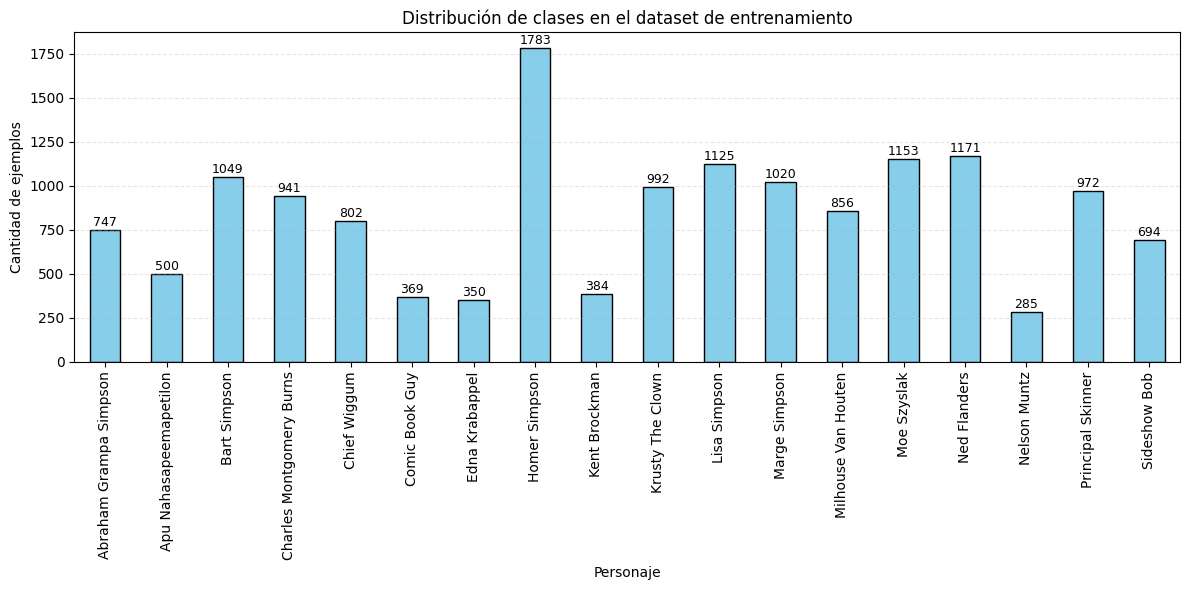

In [ ]:
# Convertimos las etiquetas a un DataFrame para contar ocurrencias
df_labels = pd.DataFrame({'label': y_train})
counts = df_labels['label'].value_counts().sort_index()

# Obtener nombres de clase más legibles (reemplazando guiones bajos por espacios)
class_names = [MAP_CHARACTERS[i].replace('_', ' ').title() for i in counts.index]

# Crear gráfico
ax = counts.plot(kind='bar', figsize=(12, 6), color='skyblue', edgecolor='black')

# Añadir etiquetas encima de las barras
for i, value in enumerate(counts):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=9)

# Configurar etiquetas y estilos
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=90)
plt.xlabel("Personaje")
plt.ylabel("Cantidad de ejemplos")
plt.title("Distribución de clases en el dataset de entrenamiento")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

El conjunto de entrenamiento presenta un desequilibrio en la cantidad de imágenes por clase.

Los personajes con mayor representación son:

Homer Simpson con (1758) imágenes, seguido de Moe Szyslak (1163), Ned Flanders  (1153) y Bart Simpson (1094).

En contraste, hay personajes con mucha menos representación:

Nelson Muntz con solo (286) imágenes, Edna Krabappel (356) y Comic Book Guy (378).

Este desequilibrio podría afectar el rendimiento del modelo, especialmente en las clases menos representadas, favoreciendo a las más frecuentes durante el entrenamiento.

#Data Augmentation

Debido a la significativa diferencia en la cantidad de imágenes entre algunas clases, se aplicaron técnicas de data augmentation a todas las clases, excepto a la que posee mayor número de imágenes —Homer Simpson—. Esta estrategia busca compensar el desbalance del conjunto de datos y mejorar la capacidad de generalización del modelo.

In [ ]:
# Crear el generador de aumento
datagen = ImageDataGenerator(
    rotation_range=15,         # Rango moderado, más seguro para rostros y figuras
    width_shift_range=0.1,     # Pequeños desplazamientos horizontales
    height_shift_range=0.1,    # Pequeños desplazamientos verticales
    shear_range=0.05,          # Inclinaciones leves para no distorsionar caras
    zoom_range=0.1,            # Zoom leve para variar escala
    fill_mode='nearest'        # Mantiene continuidad visual al rellenar bordes
)

# Contar imágenes por clase
class_counts = collections.Counter(y_train)
max_count = max(class_counts.values())
print("Distribución original:", class_counts)

X_augmented = []
y_augmented = []

for class_label, count in class_counts.items():
    if count < max_count:
        n_to_generate = max_count - count
        print(f"Aumentando clase {class_label} ({MAP_CHARACTERS[class_label]}): generando {n_to_generate} imágenes...")

        # Obtener solo las imágenes de esta clase
        class_indices = np.where(y_train == class_label)[0]
        class_images = X_train[class_indices]

        # Elegir imágenes aleatorias para aumentar
        for _ in range(n_to_generate):
            img = random.choice(class_images)
            img = np.expand_dims(img, axis=0)
            augmented_img = next(datagen.flow(img, batch_size=1))[0].astype('uint8')
            X_augmented.append(augmented_img)
            y_augmented.append(class_label)

# Combinar datos originales + aumentados
X_train = np.concatenate([X_train, np.array(X_augmented)], axis=0)
y_train = np.concatenate([y_train, np.array(y_augmented)], axis=0)

# Verificar nueva distribución
print("Nueva distribución balanceada:", collections.Counter(y_train))

Distribución original: Counter({np.int64(7): 1783, np.int64(14): 1171, np.int64(13): 1153, np.int64(10): 1125, np.int64(2): 1049, np.int64(11): 1020, np.int64(9): 992, np.int64(16): 972, np.int64(3): 941, np.int64(12): 856, np.int64(4): 802, np.int64(0): 747, np.int64(17): 694, np.int64(1): 500, np.int64(8): 384, np.int64(5): 369, np.int64(6): 350, np.int64(15): 285})
Aumentando clase 5 (comic_book_guy): generando 1414 imágenes...
Aumentando clase 11 (marge_simpson): generando 763 imágenes...
Aumentando clase 13 (moe_szyslak): generando 630 imágenes...
Aumentando clase 9 (krusty_the_clown): generando 791 imágenes...
Aumentando clase 1 (apu_nahasapeemapetilon): generando 1283 imágenes...
Aumentando clase 2 (bart_simpson): generando 734 imágenes...
Aumentando clase 3 (charles_montgomery_burns): generando 842 imágenes...
Aumentando clase 6 (edna_krabappel): generando 1433 imágenes...
Aumentando clase 4 (chief_wiggum): generando 981 imágenes...
Aumentando clase 17 (sideshow_bob): generando

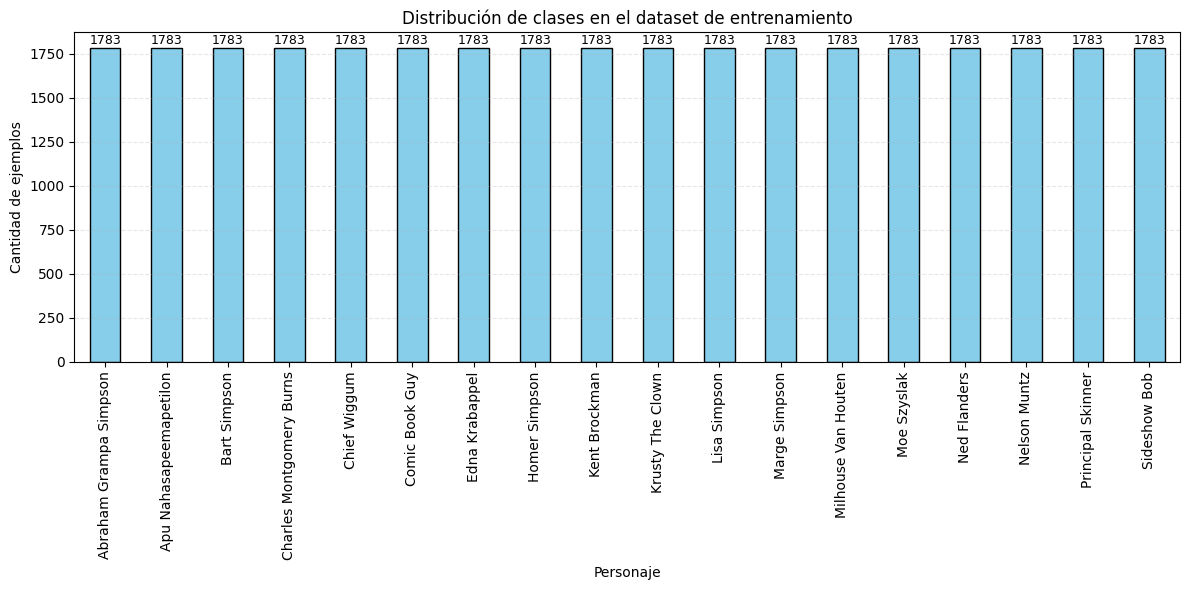

In [ ]:
# Convertimos las etiquetas a un DataFrame para contar ocurrencias
df_labels = pd.DataFrame({'label': y_train})
counts = df_labels['label'].value_counts().sort_index()

# Obtener nombres de clase más legibles (reemplazando guiones bajos por espacios)
class_names = [MAP_CHARACTERS[i].replace('_', ' ').title() for i in counts.index]

# Crear gráfico
ax = counts.plot(kind='bar', figsize=(12, 6), color='skyblue', edgecolor='black')

# Añadir etiquetas encima de las barras
for i, value in enumerate(counts):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=9)

# Configurar etiquetas y estilos
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=90)
plt.xlabel("Personaje")
plt.ylabel("Cantidad de ejemplos")
plt.title("Distribución de clases en el dataset de entrenamiento")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Se puede observar que ahora todas las clases cuentan con la misma cantidad de imágenes, lo que debería traducirse en un menor sobreentrenamiento de los modelos.

# One-hot encoding y Normalización


Se utiliza one-hot encoding para convertir los números de las clases de los personajes en un vector binario (Clase 4 → [0, 0, 0, 0, 1, ..., 0]). Esta transformación permite que el modelo no interprete un orden en las clases, haciendo que todas tengan el mismo peso. Además, permite usar categorical_crossentropy como función de pérdida, ideal para casos de clasificación multiclase.

Se normalizan los valores de los píxeles de las imágenes (0 a 255) para convertirlos en valores entre 0 y 1, evitando así problemas de escala y mejorando tanto la velocidad como el rendimiento de los modelos.

In [ ]:
y_train = to_categorical(y_train, num_classes=len(MAP_CHARACTERS))
y_val = to_categorical(y_val, num_classes=len(MAP_CHARACTERS))
y_test = to_categorical(y_test, num_classes=len(MAP_CHARACTERS))

y_train_b = to_categorical(y_train_b, num_classes=len(MAP_CHARACTERS))
y_val_b = to_categorical(y_val_b, num_classes=len(MAP_CHARACTERS))

X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

X_train_b = X_train_b.astype("float32") / 255.0
X_val_b = X_val_b.astype("float32") / 255.0

# Definición de modelos

En las siguientes secciones se definen y entrenan diversos modelos, con el objetivo de encontrar una arquitectura que se ajuste a nuestro dataset y tenga un rendimiento aceptable.

## Callbacks

Se usa Early Stopping para evitar el sobreajuste, deteniendo el entrenamiento cuando la precisión en el conjunto de validación deja de mejorar. Esto ayuda a obtener un modelo más generalizable sin perder tiempo entrenando innecesariamente.

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Modelo 1 (FNN)

### Arquitectura

Esta es una red neuronal completamente conectada, que se utilizará como referencia para comparar con los modelos CNN.

In [ ]:
np.random.seed(12)
tf.random.set_seed(12)

model_fnn = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),

    tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(18, activation='softmax')
])

model_fnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_fnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_9 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,251,858 (50.55 MB)

 Trainable params: 13,248,274 (50.54 MB)

 Non-trainable params: 3,584 (14.00 KB)

La arquitectura utiliza una capa Flatten para convertir la imagen en un vector, seguida de tres capas densas (1024, 512 y 256 neuronas) con activación ReLU y el inicializador he_normal. Se agregan BatchNormalization y Dropout para mejorar el aprendizaje y reducir el sobreajuste.

La capa de salida cuenta con 18 neuronas y activación softmax para realizar la clasificación multiclase.

Se está usando Adam, que en la mayoría de los casos consigue una convergencia más rápida.

### Entrenamiento modelo 1

In [ ]:
time_start = time.time()

hist_fnn = model_fnn.fit(
    X_train_b, y_train_b,
    batch_size=64,
    epochs=30,
    validation_data=(X_val_b, y_val_b),
    callbacks=[early_stop],
)

time_fnn = time.time() - time_start

Epoch 1/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1825 - loss: 2.9180 - val_accuracy: 0.3067 - val_loss: 2.3423
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3406 - loss: 2.2318 - val_accuracy: 0.3533 - val_loss: 2.1622
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3762 - loss: 2.0751 - val_accuracy: 0.3525 - val_loss: 2.1604
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3998 - loss: 1.9740 - val_accuracy: 0.3898 - val_loss: 1.9936
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4200 - loss: 1.8990 - val_accuracy: 0.3835 - val_loss: 1.9933
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4266 - loss: 1.8746 - val_accuracy: 0.3680 - val_loss: 2.0532
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4368 - loss: 1.8657 - val_accuracy: 0.3883 - val_loss: 1.9698
Epoch 8/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4409 - loss: 1.8129 - val_accuracy: 0

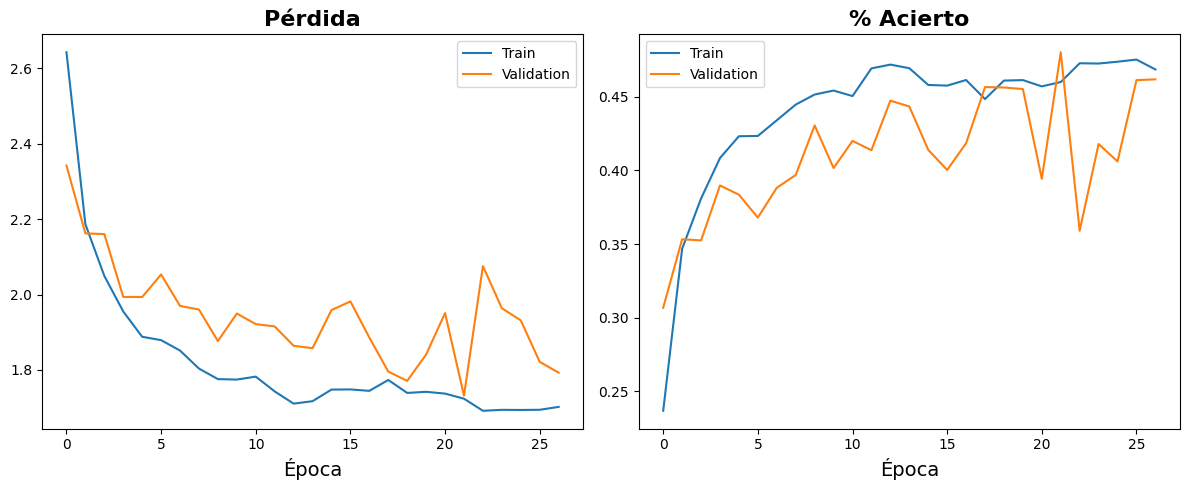

In [ ]:
# Muestra la pérdida y el acierto por cada época

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0].plot(hist_fnn.history['loss'], label="Train")
axs[0].plot(hist_fnn.history['val_loss'], label="Validation")
axs[0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=14)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(hist_fnn.history['accuracy'], label="Train")
axs[1].plot(hist_fnn.history['val_accuracy'], label="Validation")
axs[1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

Se puede observar que el modelo no presenta una precisión (accuracy) elevada, con una pérdida considerable y sobreentrenamiento, lo que se refleja en la discrepancia entre los resultados de entrenamiento y prueba.

Esto puede deberse a la simplicidad de su arquitectura. En los siguientes modelos se probarán más variaciones, incluyendo capas convolucionales.


### Evaluación modelo 1

In [ ]:
loss, accuracy = model_fnn.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred_probs = model_fnn.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

target_names = [MAP_CHARACTERS[i] for i in sorted(MAP_CHARACTERS.keys())]

report_fnn = classification_report(y_true, y_pred, target_names=target_names)
print(report_fnn)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5448 - loss: 1.5754
Test Loss: 1.5615403652191162
Test Accuracy: 0.5370786786079407
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.36      0.33      0.34        48
  apu_nahasapeemapetilon       0.94      0.66      0.78        50
            bart_simpson       0.36      0.42      0.39        50
charles_montgomery_burns       0.64      0.60      0.62        48
            chief_wiggum       0.73      0.72      0.73        50
          comic_book_guy       0.92      0.22      0.36        49
          edna_krabappel       0.83      0.20      0.32        50
           homer_simpson       0.24      0.70      0.36        50
           kent_brockman       0.67      0.80      0.73        50
        krusty_the_clown       0.64      0.74      0.69        50
            lisa_simpson       1.00      0.04      0.08        50
           marge_simpson     

Se puede observar que las métricas al evaluar con el dataset de prueba presentan una alta variabilidad dependiendo de la clase; por ejemplo, "apu_nahasapeemapetilon" presenta un buen desempeño con un F1-score de 0.78, mientras que "edna_krabappel" presenta un 0.32. Esta diferencia entre clases indica un claro sesgo o que el modelo no está aprendiendo las características clave de la clase.

## Modelo 2 (CNN Base)

### Arquitectura

In [ ]:
model_ccn_base = tf.keras.models.Sequential()
model_ccn_base.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3), activation="relu"))
model_ccn_base.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model_ccn_base.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_ccn_base.add(tf.keras.layers.Dropout(0.2))

model_ccn_base.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model_ccn_base.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model_ccn_base.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_ccn_base.add(tf.keras.layers.Dropout(0.2))

model_ccn_base.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation="relu"))
model_ccn_base.add(tf.keras.layers.Conv2D(256, (3, 3), activation="relu"))
model_ccn_base.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_ccn_base.add(tf.keras.layers.Dropout(0.2))

model_ccn_base.add(tf.keras.layers.Flatten())
model_ccn_base.add(tf.keras.layers.Dense(1024, activation="relu"))
model_ccn_base.add(tf.keras.layers.Dropout(0.5))
model_ccn_base.add(tf.keras.layers.Dense(18, activation='softmax'))

model_ccn_base.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │        18,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,260,018 (39.14 MB)

 Trainable params: 10,260,018 (39.14 MB)

 Non-trainable params: 0 (0.00 B)

El modelo CNN consta de tres bloques convolucionales con filtros crecientes (32 → 64 → 256), seguidos de MaxPooling y Dropout para reducir la dimensionalidad y prevenir el sobreajuste.

Tras aplanar (Flatten) las características extraídas, se añade una capa densa de 1,024 neuronas con Dropout, y una capa final softmax de 18 salidas para clasificar a los personajes de Los Simpsons

### Entrenamiento modelo 2

In [ ]:
model_ccn_base.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)


time_start = time.time()

hist_cnn_base = model_ccn_base.fit(
    X_train_b, y_train_b,
    batch_size=64,
    epochs=30,
    validation_data=(X_val_b, y_val_b),
    callbacks=[early_stop]
)

time_cnn = time.time() - time_start

Epoch 1/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.1265 - loss: 2.7701 - val_accuracy: 0.3314 - val_loss: 2.1153
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.3996 - loss: 1.9325 - val_accuracy: 0.6457 - val_loss: 1.1665
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6528 - loss: 1.1539 - val_accuracy: 0.7328 - val_loss: 0.8876
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7505 - loss: 0.8209 - val_accuracy: 0.7734 - val_loss: 0.7600
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8114 - loss: 0.6188 - val_accuracy: 0.8297 - val_loss: 0.5852
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8495 - loss: 0.4781 - val_accuracy: 0.8500 - val_loss: 0.5225
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8793 - loss: 0.3926 - val_accuracy: 0.8602 - val_loss: 0.5034
Epoch 8/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8962 - loss: 0.3273 - val_ac

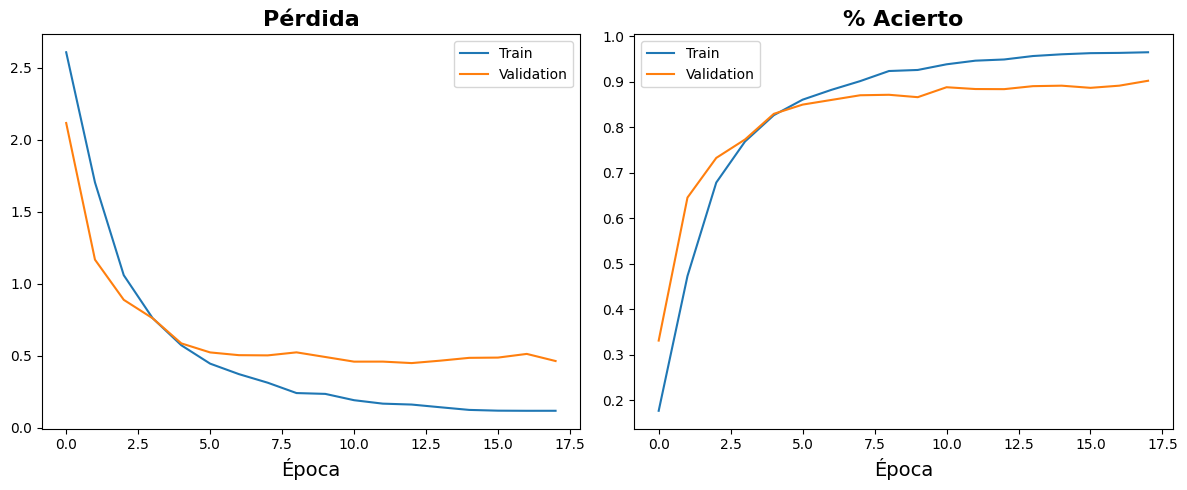

In [ ]:
# Muestra la pérdida y el acierto por cada época

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0].plot(hist_cnn_base.history['loss'], label="Train")
axs[0].plot(hist_cnn_base.history['val_loss'], label="Validation")
axs[0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=14)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(hist_cnn_base.history['accuracy'], label="Train")
axs[1].plot(hist_cnn_base.history['val_accuracy'], label="Validation")
axs[1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Primer modelo: hist_adam
plot_accuracy_bars(hist_fnn, sub_titulo="Adam base", ax=axes[0, 0])
plot_loss_bars(hist_fnn, sub_titulo="Adam base", ax=axes[0, 1])

# Segundo modelo: hist_adam_act
plot_accuracy_bars(hist_cnn_base, sub_titulo="Adam layers = 4", ax=axes[1, 0])
plot_loss_bars(hist_cnn_base, sub_titulo="Adam layers = 4", ax=axes[1, 1])

plt.tight_layout()
plt.show()

Se observa que el modelo muestra una mejora significativa en precisión y reducción de la pérdida en comparación con el modelo anterior.

Sin embargo, aún presenta señales de sobreentrenamiento, evidenciadas por la diferencia entre la precisión en entrenamiento y en validación, lo que sugiere que el modelo está demasiado ajustado a los datos de entrenamiento.

Esto puede atribuirse a la arquitectura utilizada. En los siguientes modelos, se probarán más variaciones.

### Evaluación modelo 2

In [ ]:
loss, accuracy = model_ccn_base.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred_probs = model_ccn_base.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

target_names = [MAP_CHARACTERS[i] for i in sorted(MAP_CHARACTERS.keys())]

report_cnn = classification_report(y_true, y_pred, target_names=target_names)
print(report_cnn)

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9630 - loss: 0.1680
Test Loss: 0.17098118364810944
Test Accuracy: 0.9595505595207214
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.90      0.93        48
  apu_nahasapeemapetilon       1.00      0.98      0.99        50
            bart_simpson       0.92      0.90      0.91        50
charles_montgomery_burns       0.92      0.96      0.94        48
            chief_wiggum       1.00      0.98      0.99        50
          comic_book_guy       1.00      0.94      0.97        49
          edna_krabappel       1.00      0.88      0.94        50
           homer_simpson       0.86      0.98      0.92        50
           kent_brockman       0.98      0.96      0.97        50
        krusty_the_clown       0.98      1.00      0.99        50
            lisa_simpson       0.89      0.98      0.93        50
           marge_simpson    

Los resultados muestran un desempeño claramente superior al del modelo FNN. La mayoría de las clases presentan valores aceptables en las tres métricas; sin embargo, todavía existen clases puntuales cuyo rendimiento podría mejorar, como es el caso de Bart Simpson.

## Modelo 2 (CNN Aumentado)

### Arquitectura

Este es el mismo modelo que el anterior, pero entrenado con los datos aumentados. Se espera observar un menor sobreentrenamiento.

In [ ]:
model_cnn_aug = tf.keras.models.Sequential()
model_cnn_aug.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3), activation="relu"))
model_cnn_aug.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model_cnn_aug.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_aug.add(tf.keras.layers.Dropout(0.2))

model_cnn_aug.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model_cnn_aug.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model_cnn_aug.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_aug.add(tf.keras.layers.Dropout(0.2))

model_cnn_aug.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation="relu"))
model_cnn_aug.add(tf.keras.layers.Conv2D(256, (3, 3), activation="relu"))
model_cnn_aug.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_aug.add(tf.keras.layers.Dropout(0.2))

model_cnn_aug.add(tf.keras.layers.Flatten())
model_cnn_aug.add(tf.keras.layers.Dense(1024, activation="relu"))
model_cnn_aug.add(tf.keras.layers.Dropout(0.5))
model_cnn_aug.add(tf.keras.layers.Dense(18, activation='softmax'))

model_cnn_aug.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 31, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 29, 29, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │        18,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,260,018 (39.14 MB)

 Trainable params: 10,260,018 (39.14 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento modelo 2 (Data augmentation)

In [ ]:
model_cnn_aug.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

time_start = time.time()

hist_cnn_aug = model_cnn_aug.fit(
    X_train,y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_val,y_val),
    callbacks=[early_stop]
)

time_cnn_aug = time.time() - time_start

Epoch 1/30
495/495 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.2009 - loss: 2.5222 - val_accuracy: 0.5815 - val_loss: 1.3493
Epoch 2/30
495/495 ━━━━━━━━━━━━━━━━━━━━ 30s 30ms/step - accuracy: 0.6077 - loss: 1.3104 - val_accuracy: 0.7115 - val_loss: 0.9425
Epoch 3/30
495/495 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.7399 - loss: 0.8616 - val_accuracy: 0.7776 - val_loss: 0.7343
Epoch 4/30
495/495 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8070 - loss: 0.6296 - val_accuracy: 0.8234 - val_loss: 0.5942
Epoch 5/30
495/495 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8546 - loss: 0.4683 - val_accuracy: 0.8394 - val_loss: 0.5464
Epoch 6/30
495/495 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.8771 - loss: 0.3870 - val_accuracy: 0.8715 - val_loss: 0.4559
Epoch 7/30
495/495 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9003 - loss: 0.3172 - val_accuracy: 0.8839 - val_loss: 0.4444
Epoch 8/30
495/495 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9137 - loss: 0.2791 - 

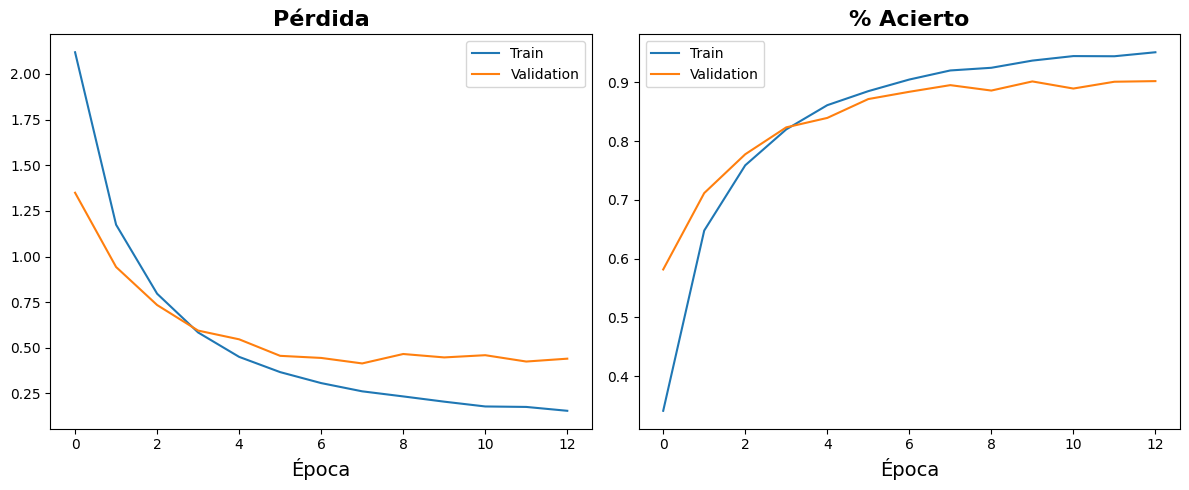

In [ ]:
# Muestra la pérdida y el acierto por cada época

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0].plot(hist_cnn_aug.history['loss'], label="Train")
axs[0].plot(hist_cnn_aug.history['val_loss'], label="Validation")
axs[0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=14)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(hist_cnn_aug.history['accuracy'], label="Train")
axs[1].plot(hist_cnn_aug.history['val_accuracy'], label="Validation")
axs[1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

El modelo está mostrando un buen rendimiento en términos de precisión, tanto en entrenamiento como en validación, con una reducción en la pérdida.

Sin embargo, aunque la diferencia entre la precisión de entrenamiento y validación se ha reducido, aún es posible que esté comenzando a sobreajustarse a los datos de entrenamiento en las últimas épocas.

Se observa un menor sobreentrenamiento en comparación con los datos originales.

En general, el modelo sigue funcionando bien, pero para asegurar su generalización, se podrían probar más variaciones.

### Evaluación modelo 2 (Data augmentation)

In [ ]:
loss, accuracy = model_cnn_aug.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred_probs = model_cnn_aug.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

target_names = [MAP_CHARACTERS[i] for i in sorted(MAP_CHARACTERS.keys())]

report_cnn_aug = classification_report(y_true, y_pred, target_names=target_names)
print(report_cnn_aug)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9674 - loss: 0.1434
Test Loss: 0.1587880551815033
Test Accuracy: 0.9617977738380432
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.94      0.94        48
  apu_nahasapeemapetilon       1.00      0.98      0.99        50
            bart_simpson       0.92      0.96      0.94        50
charles_montgomery_burns       0.98      0.96      0.97        48
            chief_wiggum       0.96      1.00      0.98        50
          comic_book_guy       0.98      1.00      0.99        49
          edna_krabappel       1.00      0.96      0.98        50
           homer_simpson       0.86      0.96      0.91        50
           kent_brockman       0.98      1.00      0.99        50
        krusty_the_clown       1.00      0.98      0.99        50
            lisa_simpson       0.96      0.86      0.91        50
           marge_simpson     

Tras aplicar Data Augmentation, se puede observar que, con el dataset de prueba, los resultados son sólidos. Todas las clases presentan un F1-score, aunque en ciertas clases, como Moe Szyslak, al aumentar el número de imágenes, su precisión bajó, pero su recall aumentó. Esto se debe a que, con más imágenes, el modelo aprendió a detectar mejor los casos positivos.

También se aprecia una leve mejora en el accuracy y la pérdida en el test.

## Modelo 3 (CNN Max)

### Arquitectura

In [ ]:
model_cnn_max = tf.keras.models.Sequential()
model_cnn_max.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3), activation="relu"))
model_cnn_max.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_max.add(tf.keras.layers.Dropout(0.2))

model_cnn_max.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding='same'))
model_cnn_max.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_max.add(tf.keras.layers.Dropout(0.2))

model_cnn_max.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model_cnn_max.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_max.add(tf.keras.layers.Dropout(0.3))

model_cnn_max.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
model_cnn_max.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_cnn_max.add(tf.keras.layers.Dropout(0.3))

model_cnn_max.add(tf.keras.layers.Flatten())
model_cnn_max.add(tf.keras.layers.Dropout(0.4))

model_cnn_max.add(tf.keras.layers.Dense(512, activation='relu'))
model_cnn_max.add(tf.keras.layers.Dense(18, activation='softmax'))

model_cnn_max.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160,818 (4.43 MB)

 Trainable params: 1,160,818 (4.43 MB)

 Non-trainable params: 0 (0.00 B)

Este modelo CNN está compuesto por cuatro bloques convolucionales.

Cada bloque incluye una única capa Conv2D con activación ReLU, seguida de una capa MaxPooling2D para reducir la dimensión espacial, y Dropout para evitar el sobreajuste.

Los filtros aumentan progresivamente (32 → 64 → 128), permitiendo capturar desde características simples hasta más complejas.

Después de aplanar las características con Flatten, se aplica Dropout, seguida de una capa densa de 512 neuronas y, finalmente, una capa softmax con 18 salidas para la clasificación.

Este modelo es más ligero que el Modelo 2, ya que cuenta con una sola capa de convolución por bloque, lo que reduce el tiempo de entrenamiento y optimiza el uso de recursos.

### Entrenamiento modelo 3

In [ ]:
model_cnn_max.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

time_start = time.time()

hist_cnn_max = model_cnn_max.fit(
    X_train,y_train,
    batch_size=64,
    epochs=50,
    validation_data=(X_val,y_val),
    callbacks=[early_stop]
)

time_cnn_max = time.time() - time_start

Epoch 1/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.1948 - loss: 2.5367 - val_accuracy: 0.5420 - val_loss: 1.5271
Epoch 2/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5890 - loss: 1.3439 - val_accuracy: 0.6878 - val_loss: 1.0173
Epoch 3/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7021 - loss: 0.9605 - val_accuracy: 0.7599 - val_loss: 0.7906
Epoch 4/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7677 - loss: 0.7535 - val_accuracy: 0.7965 - val_loss: 0.6648
Epoch 5/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8054 - loss: 0.6235 - val_accuracy: 0.8155 - val_loss: 0.5985
Epoch 6/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8294 - loss: 0.5492 - val_accuracy: 0.8318 - val_loss: 0.5422
Epoch 7/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8577 - loss: 0.4634 - val_accuracy: 0.8508 - val_loss: 0.5014
Epoch 8/50
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8661 - loss: 0.4272 - val_accura

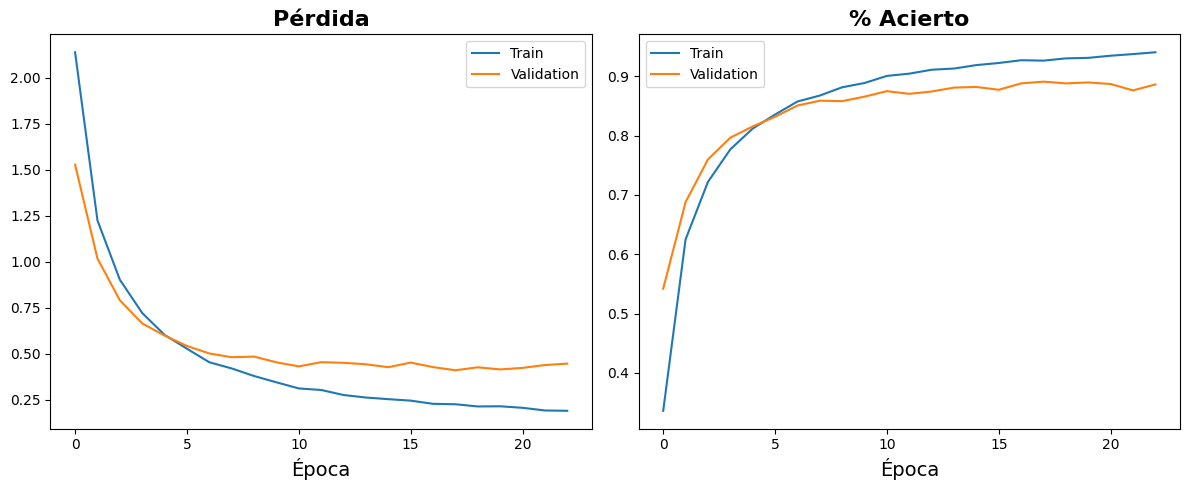

In [ ]:
# Muestra la pérdida y el acierto por cada época

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0].plot(hist_cnn_max.history['loss'], label="Train")
axs[0].plot(hist_cnn_max.history['val_loss'], label="Validation")
axs[0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=14)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(hist_cnn_max.history['accuracy'], label="Train")
axs[1].plot(hist_cnn_max.history['val_accuracy'], label="Validation")
axs[1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

Al simplificar la arquitectura en comparación con el modelo anterior, se logró mantener un rendimiento similar.

Esto evidencia que, al menos para la información que estamos utilizando, no era necesario diseñar una arquitectura de red tan compleja.

Nota: Se probó este modelo con Batch Normalization, pero en esta ocasión hubo un aumento del sobreentrenamiento, por lo que se decidió no implementarlo.

### Evaluación modelo 3

In [ ]:
loss, accuracy = model_cnn_max.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred_probs = model_cnn_max.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

target_names = [MAP_CHARACTERS[i] for i in sorted(MAP_CHARACTERS.keys())]

report_cnn_max = classification_report(y_true, y_pred, target_names=target_names)
print(report_cnn_max)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9713 - loss: 0.1516
Test Loss: 0.12342145293951035
Test Accuracy: 0.9741572737693787
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      0.98      0.96        48
  apu_nahasapeemapetilon       0.98      1.00      0.99        50
            bart_simpson       0.94      0.98      0.96        50
charles_montgomery_burns       0.98      0.96      0.97        48
            chief_wiggum       1.00      0.98      0.99        50
          comic_book_guy       1.00      1.00      1.00        49
          edna_krabappel       1.00      0.90      0.95        50
           homer_simpson       0.90      0.94      0.92        50
           kent_brockman       0.94      0.98      0.96        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       0.98      0.90      0.94        50
           marge_simpson    

Las métricas como precisión, recall y F1-score se mantienen bastante similares al modelo anterior. Sin embargo, se puede apreciar una mejora en el accuracy y en la pérdida al evaluar con el conjunto de datos de prueba.

### Guardado del mejor modelo

In [ ]:
model_cnn_max.save('cnn_max.keras')

# Conclusión

In [ ]:
results = get_final_results(hist_fnn, hist_cnn_base, hist_cnn_aug, hist_cnn_max)

# Crear el DataFrame
df_resultados = pd.DataFrame(results)

# Mostrar tabla
df_resultados

,Modelo,Train Accuracy,Train Loss,Val Accuracy,Val Loss
0,FNN,0.468703,1.701714,0.461964,1.792567
1,CNN Base,0.964984,0.117285,0.902343,0.462733
2,CNN Aumentado,0.951207,0.154855,0.902080,0.440352
3,CNN Max,0.940581,0.189912,0.886286,0.446291


Aunque el modelo CNN Aumentado es bastante similar al modelo CNN Max, se puede observar una mejor capacidad de generalización y un menor sobreajuste por parte del modelo CNN Max al evaluar con el conjunto de datos de prueba.

Por estas razones, se escogió como `Mejor modelo: CNN Max`.

# Propuestas de mejoras

- Implementar un enfoque de generación dinámica de imágenes (data augmentation en tiempo real), lo que permitiría crear nuevas variaciones de los datos en cada época sin necesidad de almacenarlas previamente, mejorando la generalización del modelo.

- Experimentar con diferentes valores de stride en las capas convolucionales, con el fin de modificar la forma en que los kernels recorren la imagen y explorar cómo esto afecta el aprendizaje de patrones.

- Ajustar los parámetros de data augmentation para encontrar una configuración más óptima que contribuya a reducir el sobreajuste sin afectar negativamente el desempeño en el conjunto de prueba.

- Incorporar un kernel regularizer (por ejemplo, L1 o L2) en las capas densas y/o convolucionales, para ayudar a controlar el sobreentrenamiento penalizando pesos excesivamente grandes.

- Probar con distintos optimizadores

# Ejemplo predicciones con el mejor modelo (CNN Max)

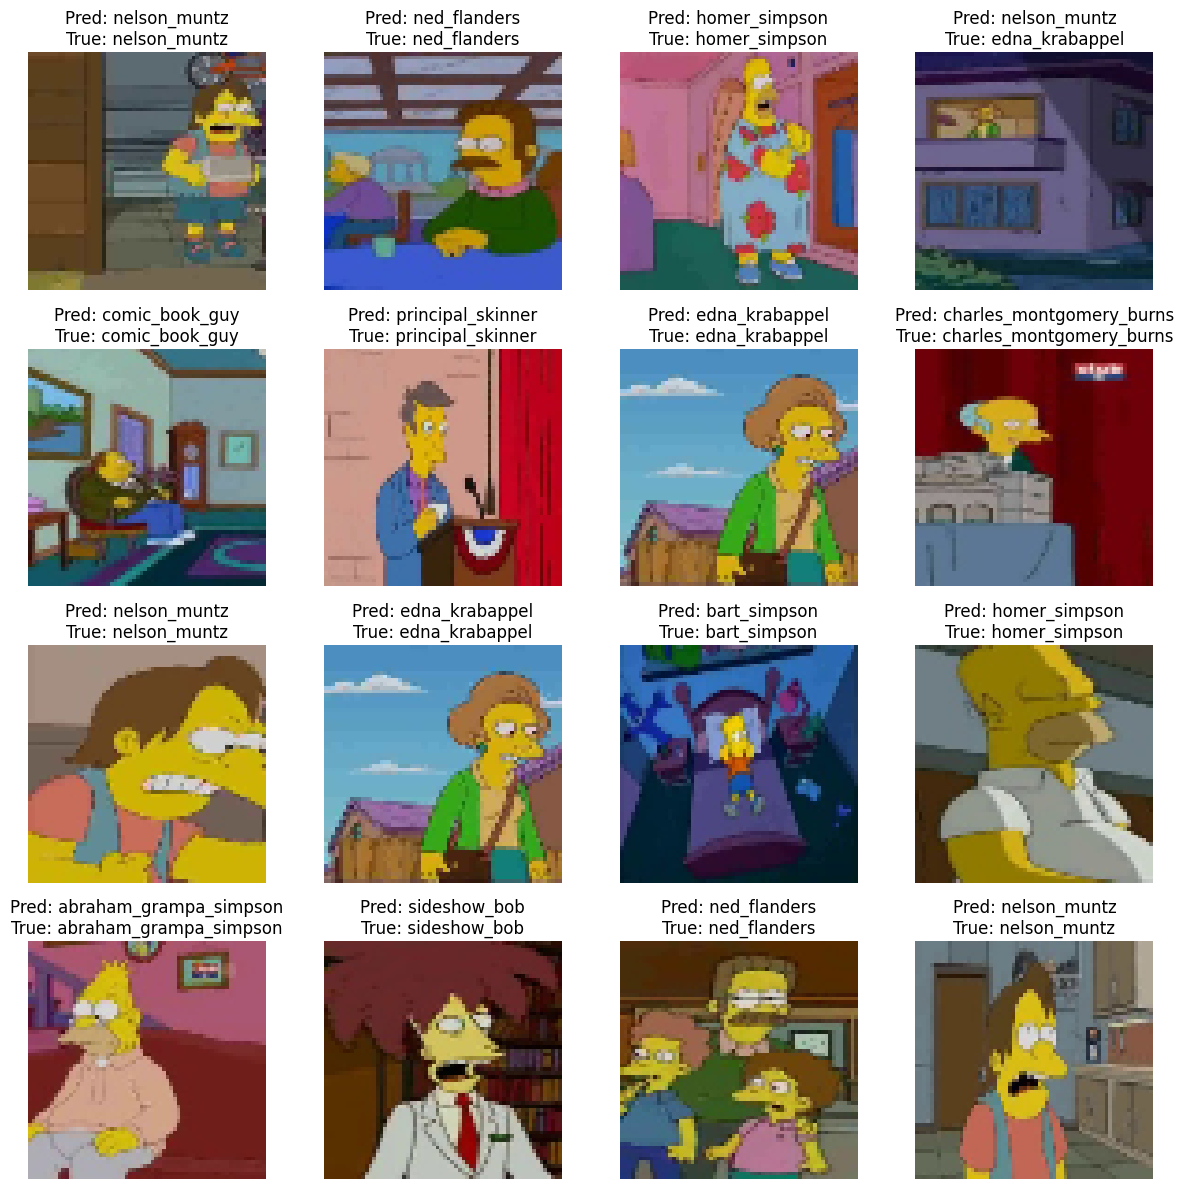

In [ ]:
num_images = 16
plt.figure(figsize=(12, 12))

for i in range(num_images):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_test[i])
    true_label = MAP_CHARACTERS[y_true[i]]
    pred_label = MAP_CHARACTERS[y_pred[i]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()